In [ ]:
!pip install yfinance

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import datetime as dt

 Download DATA of S&P 500 from yfinance

In [4]:
start = '1960-01-01'
end = '2023-01-01'
spy = yf.download(tickers='^GSPC', interval = '1d', start = start, end = end)

[*********************100%***********************]  1 of 1 completed


Data from building permit

In [ ]:
BP = pd.read_excel('PERMIT.xls', index_col=0, na_values=['observation_date', 'PERMIT']) 

BP.plot(title = "BP")

recession = [('1953-07-01', '1954-05-01'),('1957-08-01', '1958-04-01'),('1960-04-01', '1961-02-01'),('1969-12-01', '1970-11-01'),('1973-11-01', '1975-03-01'),('1980-01-01', '1980-07-01'),('1981-07-01', '1982-11-01'),('1990-07-01', '1991-03-01'),('2001-03-01', '2001-11-01'),('2007-12-01', '2009-06-01'),('2020-02-01', '2020-04-01')]

for period in recession:
    plt.axvspan(period[0], period[1], color='gray', alpha=0.2)

plt.xlabel("Time")
plt.show()

print(BP.index[2])

From observation, the data is noisy and needed to be clean with some method first. (In my opn, I will use 1. divergence from avg, 2. Change from YoY, 3.change from high in trailing year, 4.Kalman Filter)


# Experiment: Kalman Filter


<ipython-input-6-dc57ca4da783>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BP['KF'][0:5] = BP['PERMIT'][0:5]
<ipython-input-6-dc57ca4da783>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BP['KF_MAX_1Y'][i] = np.nan
<ipython-input-6-dc57ca4da783>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BP['KF_MAX_1Y'][i] = take.max()
<ipython-input-6-dc57ca4da783>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

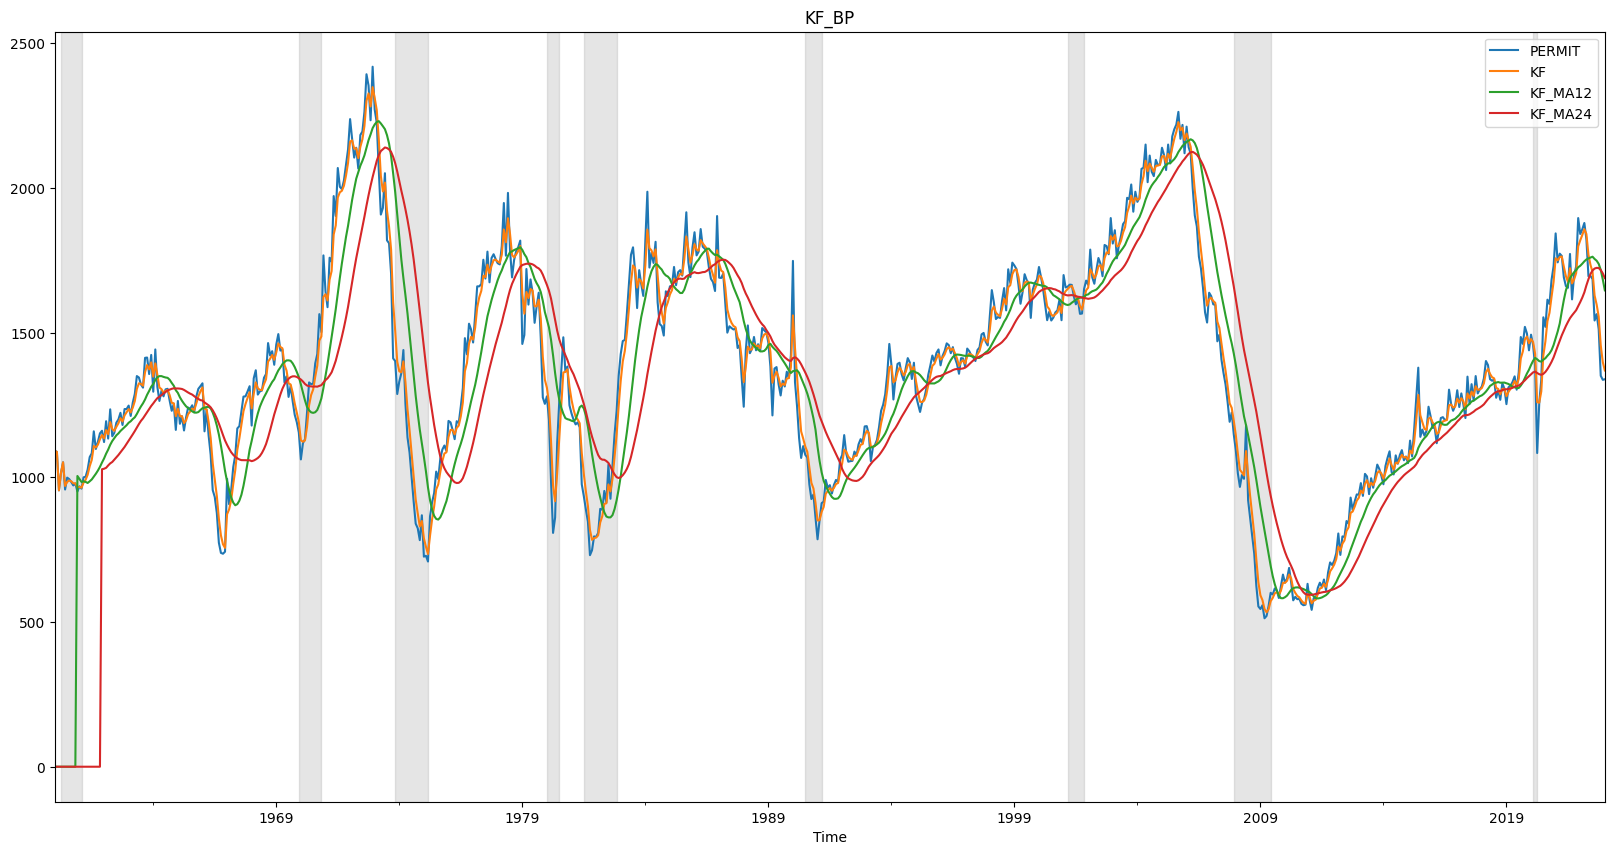

In [6]:
class KalmanFilter:
    def __init__(self, process_variance, estimated_measurement_variance):
        self.process_variance = process_variance
        self.estimated_measurement_variance = estimated_measurement_variance
        self.posteri_estimate = 0.0
        self.posteri_error_estimate = 1.0

    def noise_measurement(self, measurement):
        priori_estimate = self.posteri_estimate
        priori_error_estimate = self.posteri_error_estimate + self.process_variance

        blending_factor = priori_error_estimate / (priori_error_estimate + self.estimated_measurement_variance)
        self.posteri_estimate = priori_estimate + blending_factor * (measurement - priori_estimate)
        self.posteri_error_estimate = (1 - blending_factor) * priori_error_estimate

    def estimated_measurement(self):
        return self.posteri_estimate

# Initialize Kalman filter
kalman_filter = KalmanFilter(6, 13)

Permit = BP['PERMIT'].values

# Run Kalman filter on each measurement
KF = []
for measurement in Permit:
    kalman_filter.noise_measurement(measurement)
    forecast = kalman_filter.estimated_measurement()
    KF.append(forecast)

BP['KF'] = KF
BP['KF'][0:5] = BP['PERMIT'][0:5]
BP['KF_MA12'] = np.nan
BP['KF_MA24'] = np.nan
BP['KF_MA12_D'] = np.nan
BP['KF_MA24_D'] = np.nan
BP['recession'] = False

BP['KF_MAX_1Y'] = np.nan
for i in range(len(BP)):
  if i >= 11:
    arr = np.array(BP['KF'])
    indices = [i-k for k in range(12)]
    take = np.take(arr, indices)
    BP['KF_MAX_1Y'][i] = take.max()
  else:
    BP['KF_MAX_1Y'][i] = np.nan

for i in range(len(BP)):
  if i >= 11:
    arr = np.array(BP['KF'])
    indices = [i-k for k in range(12)]
    take = np.take(arr, indices)
    BP['KF_MA12'][i] = take.sum()/12
  else:
    BP['KF_MA12'][i] = 0

for i in range(len(BP)):
  if i >= 23:
    arr = np.array(BP['KF'])
    indices = [i-k for k in range(24)]
    take = np.take(arr, indices)
    BP['KF_MA24'][i] = take.sum()/24
  else:
    BP['KF_MA24'][i] = 0

for i in range(len(BP)):
  if i >= 23:
    arr = np.array(BP['KF_MA24'])
    indices = [i-k for k in range(2)]
    take = np.take(arr, indices)
    BP['KF_MA24_D'][i] = (take[1] - take[0])/2
  else:
    BP['KF_MA24_D'][i] = 0

for i in range(len(BP)):
  if i >= 11:
    arr = np.array(BP['KF_MA12'])
    indices = [i-k for k in range(2)]
    take = np.take(arr, indices)
    BP['KF_MA12_D'][i] = (take[1] - take[0])/2
  else:
    BP['KF_MA12_D'][i] = 0

recession = [('1953-07-01', '1954-05-01'),('1957-08-01', '1958-04-01'),('1960-04-01', '1961-02-01'),('1969-12-01', '1970-11-01'),('1973-11-01', '1975-03-01'),('1980-01-01', '1980-07-01'),('1981-07-01', '1982-11-01'),('1990-07-01', '1991-03-01'),('2001-03-01', '2001-11-01'),('2007-12-01', '2009-06-01'),('2020-02-01', '2020-04-01')]
for i in range(len(BP)):
  for period in recession:
    if (period[0] <= BP.index[i].strftime('%Y-%m-%d')) & (BP.index[i].strftime('%Y-%m-%d') <= period[1]):
      BP['recession'][i] = True

BP['CHG'] = (BP['KF'])/BP['KF_MAX_1Y']
BP['CHG_mean'] = BP['CHG'].mean()
BP['CHG+0.23sd'] = BP['CHG'].mean() + 0.23*BP['CHG'].std()

A = pd.concat([BP['PERMIT'],BP['KF'],BP['KF_MA12'],BP['KF_MA24']], axis=1)

A.plot(figsize=(20, 10),title = "KF_BP")

recession = [('1953-07-01', '1954-05-01'),('1957-08-01', '1958-04-01'),('1960-04-01', '1961-02-01'),('1969-12-01', '1970-11-01'),('1973-11-01', '1975-03-01'),('1980-01-01', '1980-07-01'),('1981-07-01', '1982-11-01'),('1990-07-01', '1991-03-01'),('2001-03-01', '2001-11-01'),('2007-12-01', '2009-06-01'),('2020-02-01', '2020-04-01')]

for period in recession:
    plt.axvspan(period[0], period[1], color='gray', alpha=0.2)

plt.xlabel("Time")
plt.show()

# Use the Data obtain from KF 

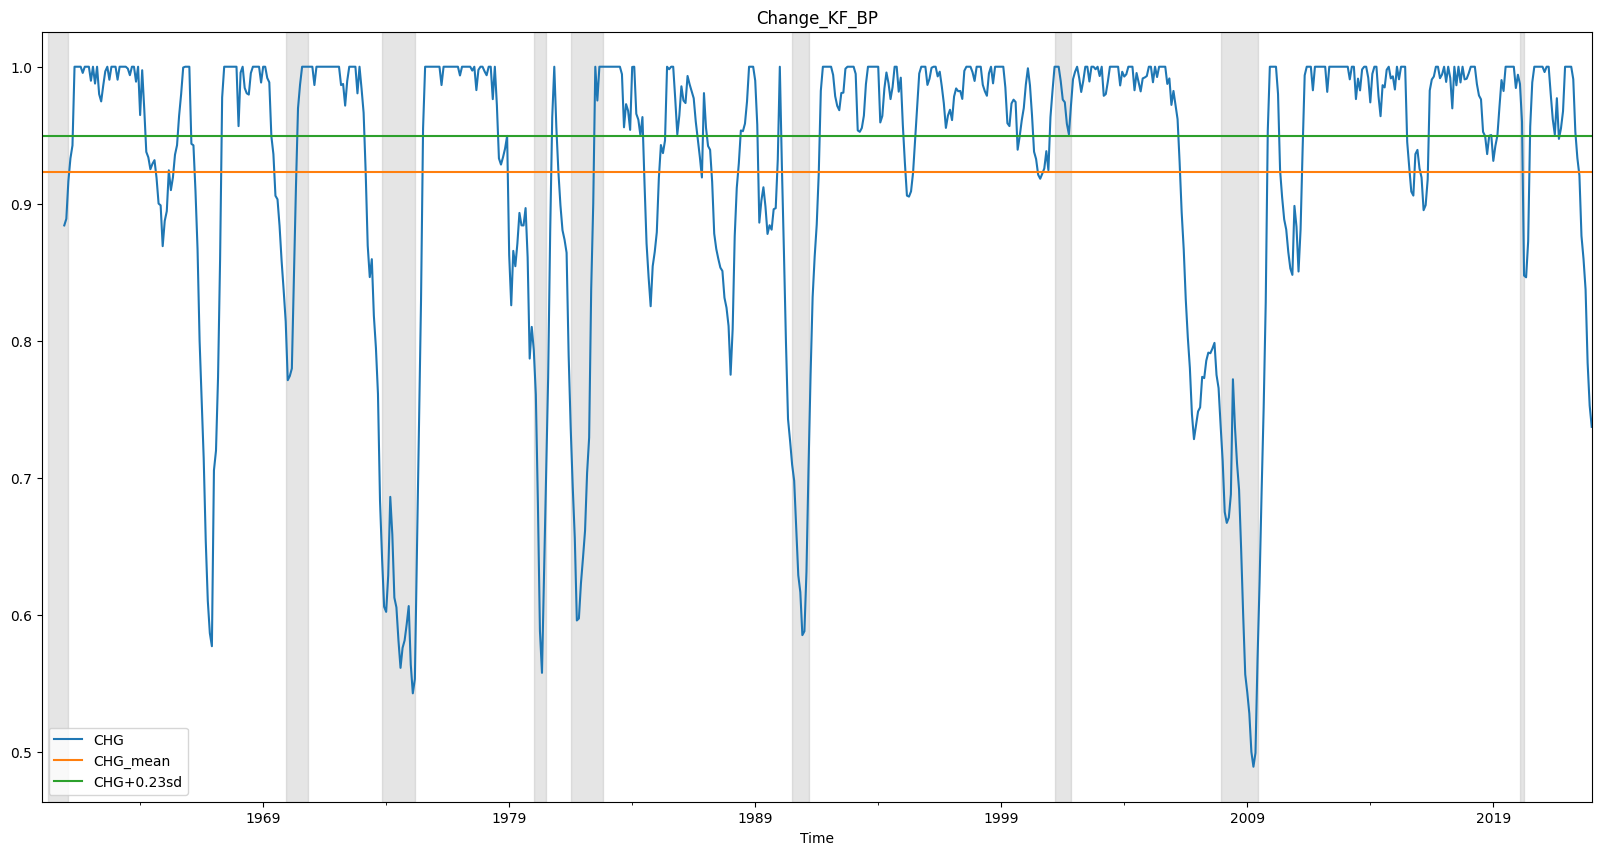

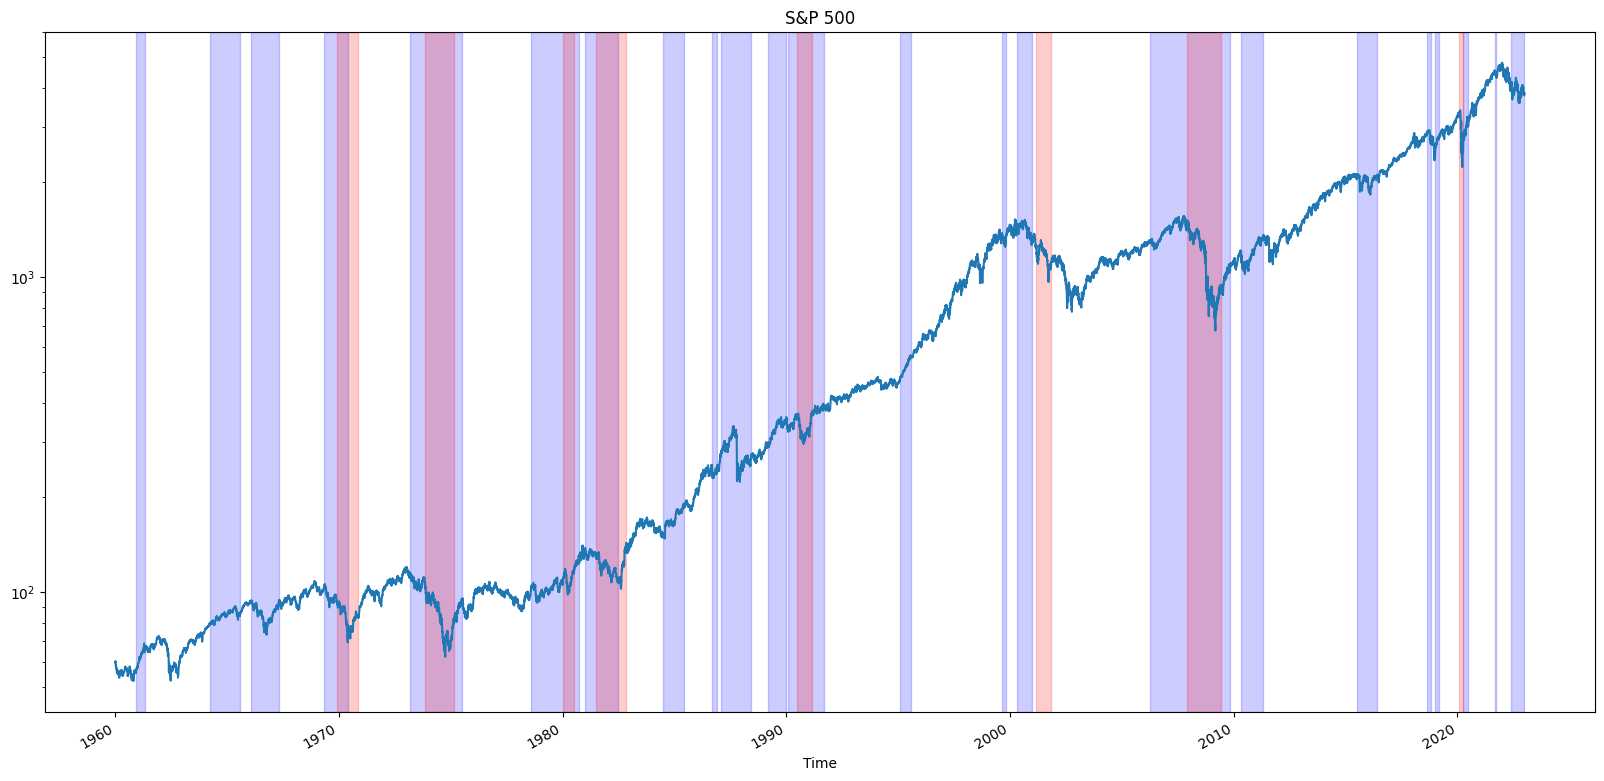

In [7]:
P = pd.concat([BP['CHG'],BP['CHG_mean'], BP['CHG+0.23sd']], axis=1)
P.plot(figsize=(20, 10),title = "Change_KF_BP")

recession = [('1953-07-01', '1954-05-01'),('1957-08-01', '1958-04-01'),('1960-04-01', '1961-02-01'),('1969-12-01', '1970-11-01'),('1973-11-01', '1975-03-01'),('1980-01-01', '1980-07-01'),('1981-07-01', '1982-11-01'),('1990-07-01', '1991-03-01'),('2001-03-01', '2001-11-01'),('2007-12-01', '2009-06-01'),('2020-02-01', '2020-04-01')]

for period in recession:
    plt.axvspan(period[0], period[1], color='gray', alpha=0.2)

plt.xlabel("Time")
plt.show()

spy['Close'].plot(figsize=(20, 10),title = "S&P 500")

BP['below_mean+0.23sd'] = (BP['CHG'] < BP['CHG+0.23sd'])
BP['above_mean+0.23sd'] = (BP['CHG'] >= BP['CHG+0.23sd'])

a = np.where(BP['below_mean+0.23sd'])
b = np.where(BP['above_mean+0.23sd'])
c = [i+1 for i in a]
x = a[0][0]
e = [x]
cb, c_ind, b_ind = np.intersect1d(c, b, return_indices=True)

e_date = []
cb_date = []

k = 0

for i in a[0]:
  if k == len(cb):
    break
  if i > cb[k]:
    e.append(i)
    k += 1

cb = cb.tolist()
cb.append(a[0][-1])

for d in e:
  Y = 1960 + d//12
  if d%12 >= 9:
    k = 1
    M = -9 + d%12
  else:
    k = 0
    M = 1+d%12
  e_date.append(f'{Y}-{k}{M}-01')

for d in cb:
  Y = 1960 + d//12
  if d%12 >= 9:
    k = 1
    M = -9 + d%12
  else:
    k = 0
    M = 1+d%12
  cb_date.append(f'{Y}-{k}{M}-01')

for i in range(len(e_date)):
  if (e_date[i] < str(spy.index[-1])[:-9])&(e_date[i] > str(spy.index[0])[:-9]):
    plt.axvspan(e_date[i],cb_date[i],color = 'b',alpha = 0.2)
  if e_date[i] > str(spy.index[-1])[:-9]:
    break

#('1953-07-01', '1954-05-01'),('1957-08-01', '1958-04-01'),('1960-04-01', '1961-02-01'),

recession = [('1969-12-01', '1970-11-01'),('1973-11-01', '1975-03-01'),('1980-01-01', '1980-07-01'),('1981-07-01', '1982-11-01'),('1990-07-01', '1991-03-01'),('2001-03-01', '2001-11-01'),('2007-12-01', '2009-06-01'),('2020-02-01', '2020-04-01')]

for period in recession:
    plt.axvspan(period[0], period[1], color='red', alpha=0.2)

plt.xlabel("Time")
plt.yscale('log')
plt.show()


Doom Clock

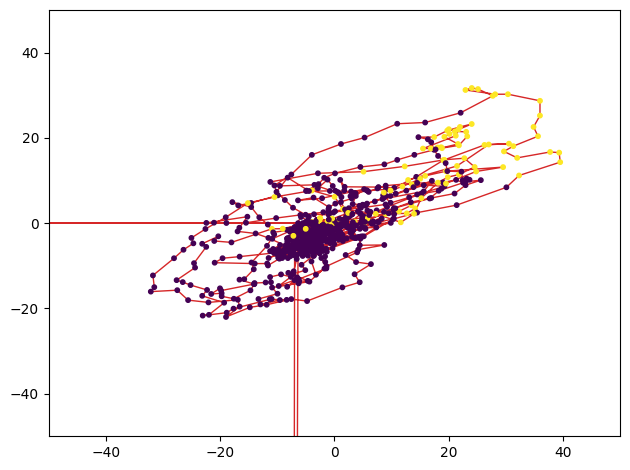

In [ ]:
A = pd.concat([BP['KF_MA12_D'],BP['KF_MA24_D'], BP['recession']], axis=1)

# for i in range(len(BP)):
#   print(i)
#   if BP['KF_MA12_D'][i] < -50 or BP['KF_MA24_D'][i] < -50:
#     BP.drop(i)

plt.plot(A['KF_MA12_D'], A['KF_MA24_D'], 'C3', lw=1)
plt.scatter(A['KF_MA12_D'], A['KF_MA24_D'], c=A['recession'],s=10, zorder=2.5)
plt.xlim(-50,50)
plt.ylim(-50,50)

plt.tight_layout()